# Lasso regression on motifs

In [1]:
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

In [227]:
cd="/data/cephfs-2/unmirrored/groups/kircher/MPRA/CaptureCMPRA/"
bins = pl.read_csv(cd+"results/MPRA_analysis/CMPRA5/labeled_data_promoteroa_OA.tsv", separator='\t').select(
	pl.col("promoter"), #.str.head(-2),
	pl.col("OE")#.str.head(-2)
	).unique()
prom_motifs = pl.read_csv(cd+"/results/motif_analysis/HOMER/upProm_find.filtered.tsv", separator='\t', has_header=False, skip_rows=1, 
	new_columns=["bin", "promoter"]).with_columns(pl.col("bin").str.replace(":", "-"), pl.col("promoter").str.split(".").list.first())
CRE_motifs = pl.read_csv(cd+"results/motif_analysis/HOMER/upOE_find.filtered.tsv", separator='\t', has_header=False, skip_rows=1, 
	new_columns=["bin", "CRE"]).with_columns(pl.col("bin").str.replace(":", "-"), pl.col("CRE").str.split(".").list.first())
binary = True


In [228]:
prom_encoded = prom_motifs.to_dummies("promoter").group_by("bin").sum()
CRE_encoded = CRE_motifs.to_dummies("CRE").group_by("bin").sum()

In [229]:
up_input = bins.join(prom_encoded, left_on="promoter", right_on="bin").join(CRE_encoded, left_on="OE", right_on="bin").unique()

In [230]:
prom_motifs = pl.read_csv(cd+"results/motif_analysis/HOMER/downProm_find.filtered.tsv", separator='\t', has_header=False, skip_rows=1, 
	new_columns=["bin", "promoter"]).with_columns(pl.col("bin").str.replace(":", "-"), pl.col("promoter").str.split(".").list.first())
CRE_motifs = pl.read_csv(cd+"results/motif_analysis/HOMER/downOE_find.filtered.tsv", separator='\t', has_header=False, skip_rows=1, 
	new_columns=["bin", "CRE"]).with_columns(pl.col("bin").str.replace(":", "-"), pl.col("CRE").str.split(".").list.first())
prom_encoded = prom_motifs.to_dummies("promoter").group_by("bin").sum()
CRE_encoded = CRE_motifs.to_dummies("CRE").group_by("bin").sum()

In [ ]:
down_input = bins.join(prom_encoded, left_on="promoter", right_on="bin").join(CRE_encoded, left_on="OE", right_on="bin").unique()

In [233]:
for col in down_input.columns:
	if col not in up_input.columns:
		print(col)

promoter_ZFAT
promoter_ZN37A
promoter_ZN436
promoter_ZN565
promoter_ZNF500
promoter_ZSC16
CRE_ZFAT
CRE_ZN490
CRE_ZN565
CRE_ZN578
CRE_ZN627
CRE_ZN736
CRE_ZNF81


In [234]:
for col in up_input.columns:
	if col not in down_input.columns:
		print(col)

promoter_OLIG1
promoter_ONEC2
promoter_ZN112
promoter_ZN160
promoter_ZN736
CRE_MTF1
CRE_POGK
CRE_Z585B
CRE_ZBED1
CRE_ZFP41
CRE_ZN37A
CRE_ZN430
CRE_ZNF92


In [235]:
for col in up_input.columns:
	if col not in down_input.columns:
		down_input = down_input.with_columns(pl.lit(0).cast(pl.Int64).alias(col))
for col in down_input.columns:
	if col not in up_input.columns:
		up_input = up_input.with_columns(pl.lit(0).cast(pl.Int64).alias(col))

In [380]:
dummies = pl.concat([up_input.select(sorted(up_input.columns)), down_input.select(sorted(down_input.columns)).sample(up_input.height)])

In [381]:
cmpra = pl.read_csv(cd+"/results/MPRA_analysis/CMPRA5/labeled_data_promoteroa_OA.tsv", separator="\t").with_columns(
	pl.col("promoter"),
	pl.col("OE")).filter(pl.col("promoter").is_not_null())

### Remove duplicates between up and down

In [382]:
dummies = dummies.filter(pl.len().over(["OE", "promoter"]) == 1)

In [383]:
max_z = cmpra.group_by(["OE", "promoter"]).agg(max_z = pl.col("z_score").abs().max())
if binary:
	output = cmpra.with_columns(id = pl.col("promoter") + pl.col("OE")) \
		.with_columns(output = pl.when(pl.col("id").is_in(up_input.select(id=pl.col("promoter") + pl.col("OE")))).then(pl.lit(1))\
			.when(pl.col("id").is_in(down_input.select(id=pl.col("promoter") + pl.col("OE")))).then(pl.lit(-1))\
				.otherwise(None)).filter(pl.col("output").is_not_null()).select("id", "output").unique()
else:
	output = cmpra.join(max_z, on=["OE", "promoter"]).filter(pl.col("z_score").abs() == pl.col("max_z")) \
		.with_columns(id=pl.col("promoter") + pl.col("OE")).select("id", "z_score")
dummies = dummies.with_columns(id=pl.col("promoter") + pl.col("OE"))#.select(pl.exclude("promoter", "OE"))

In [384]:
test_chrom = "chr17|chr6" # 15 of 6 of 17
X_test = dummies.filter(pl.col("id").str.contains(test_chrom))
X_train = dummies.filter(pl.col("id").str.contains(test_chrom).not_())
y_test = output.join(X_test, on="id", how="semi")
y_train = output.join(X_train, on="id", how="semi")
X_test = X_test.join(y_test, on=["id"], how="semi")
X_train = X_train.join(y_train, on=["id"], how="semi")
X_train, X_test = X_train.sort("id").select(pl.exclude("id", "OE", "promoter")), X_test.sort("id").select(pl.exclude("id", "OE", "promoter"))
y_train, y_test = y_train.sort("id").select(pl.exclude("id", "OE", "promoter")), y_test.sort("id").select(pl.exclude("id", "OE", "promoter"))
X = pl.concat([X_train, X_test])
y = pl.concat([y_train, y_test])

In [385]:
y_train.filter(pl.col("output") == 1).height, y_train.filter(pl.col("output") == -1).height, y_test.filter(pl.col("output") == 1).height, y_test.filter(pl.col("output") == -1).height

(888, 914, 273, 247)

In [386]:
X_train.height, X_test.height, y_train.height, y_test.height

(1802, 520, 1802, 520)

In [329]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1],  # Regularization strength
    'l1_ratio': [0.1, 0.5, 0.9]  # ElasticNet mixing parameter
}

# Initialize the logistic regression model with ElasticNet penalty
logistic = LogisticRegression(penalty='elasticnet', solver='saga', random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=logistic,
    param_grid=param_grid,
    scoring='roc_auc',  # Use ROC AUC as the evaluation metric
    cv=3,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train.to_numpy().flatten())

# Print the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best ROC AUC score:", grid_search.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/data/cephfs-1/work/groups/kircher/users/pkeukel_m/miniforge/envs/notebooks/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'C': 0.01, 'l1_ratio': 0.5}
Best ROC AUC score: 0.6134016599915273


In [408]:



# Fit Lasso Logistic Regression
lasso = LogisticRegression(penalty='elasticnet', solver='saga', C=0.009, random_state=1, l1_ratio=0.1)
lasso.fit(X_train, y_train.to_numpy().flatten())

# Get feature importance
feature_importance = pl.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso.coef_[0]
}).sort('Coefficient',descending=True)

print("Top Features:")
print(feature_importance)

# Evaluate the model
y_pred = lasso.predict(X_test)
print(classification_report(y_test, y_pred))

train_score_lr = lasso.score(X_train, y_train)
test_score_lr = lasso.score(X_test, y_test)

print("The train score for lasso model is {}".format(train_score_lr))
print("The test score for lasso model is {}".format(test_score_lr))
print("Number of selected features: {}".format(np.sum(lasso.coef_ != 0)))
roc_auc_score(y_test, y_pred)

Top Features:
shape: (1_159, 2)
┌─────────────────┬─────────────┐
│ Feature         ┆ Coefficient │
│ ---             ┆ ---         │
│ str             ┆ f64         │
╞═════════════════╪═════════════╡
│ promoter_ZNF358 ┆ 0.137923    │
│ CRE_ZN543       ┆ 0.129528    │
│ CRE_HAND1       ┆ 0.124222    │
│ promoter_ZN449  ┆ 0.124011    │
│ CRE_ZBTB5       ┆ 0.121569    │
│ …               ┆ …           │
│ CRE_HMGA1       ┆ -0.116625   │
│ promoter_CREM   ┆ -0.124852   │
│ promoter_ZFX    ┆ -0.138854   │
│ CRE_AHCTF1      ┆ -0.147801   │
│ promoter_ZN460  ┆ -0.16865    │
└─────────────────┴─────────────┘
              precision    recall  f1-score   support

          -1       0.63      0.63      0.63       247
           1       0.67      0.67      0.67       273

    accuracy                           0.65       520
   macro avg       0.65      0.65      0.65       520
weighted avg       0.65      0.65      0.65       520

The train score for lasso model is 0.7502774694783574
The test 

np.float64(0.6489300173510699)

In [338]:
print("Number of selected positive class motifs: {}".format(np.sum(lasso.coef_ > 0)))
print("Of which are enhancer motifs: {}".format(feature_importance.filter(pl.col("Coefficient") > 0).filter(pl.col("Feature").str.contains("CRE_")).height))
print("Of which are promoter motifs: {}".format(feature_importance.filter(pl.col("Coefficient") > 0).filter(pl.col("Feature").str.contains("promoter_")).height))
print("Number of motifs shared between promoter and enhancers: {}".format(feature_importance.filter(pl.col("Coefficient") > 0).select(pl.col("Feature").str.strip_prefix("promoter_").str.strip_prefix("CRE_").unique_counts())\
	.filter(pl.col("Feature") > 1).height))
feature_importance.filter(pl.col("Coefficient") > 0).select(pl.col("Feature").str.strip_prefix("promoter_").str.strip_prefix("CRE_").unique_counts())\
	.filter(pl.col("Feature") > 1).height / feature_importance.filter(pl.col("Coefficient") > 0).height

Number of selected positive class motifs: 135
Of which are enhancer motifs: 57
Of which are promoter motifs: 78
Number of motifs shared between promoter and enhancers: 15


0.1111111111111111

In [339]:
print("Number of selected negative class motifs: {}".format(np.sum(lasso.coef_ < 0)))
print("Of which are enhancer motifs: {}".format(feature_importance.filter(pl.col("Coefficient") < 0).filter(pl.col("Feature").str.contains("CRE_")).height))
print("Of which are promoter motifs: {}".format(feature_importance.filter(pl.col("Coefficient") < 0).filter(pl.col("Feature").str.contains("promoter_")).height))
print("Number of motifs shared between promoter and enhancers: {}".format(feature_importance.filter(pl.col("Coefficient") < 0).select(pl.col("Feature").str.strip_prefix("promoter_").str.strip_prefix("CRE_").unique_counts())\
	.filter(pl.col("Feature") > 1).height))
feature_importance.filter(pl.col("Coefficient") < 0).select(pl.col("Feature").str.strip_prefix("promoter_").str.strip_prefix("CRE_").unique_counts())\
	.filter(pl.col("Feature") > 1).height / feature_importance.filter(pl.col("Coefficient") < 0).height

Number of selected negative class motifs: 112
Of which are enhancer motifs: 50
Of which are promoter motifs: 62
Number of motifs shared between promoter and enhancers: 6


0.05357142857142857

In [250]:
if not binary:
	lasso = Lasso(alpha=0.01)
	lasso.fit(X_train, y_train)
	# Using np.abs() to make coefficients positive.  
	lasso1_coef = np.abs(lasso.coef_)
	y_hat = lasso.predict(X_test)

	train_score_lr = lasso.score(X_train, y_train)
	test_score_lr = lasso.score(X_test, y_test)

	print("The train score for lasso model is {}".format(train_score_lr))
	print("The test score for lasso model is {}".format(test_score_lr))

	plt.scatter(y_test.to_pandas(), y_hat)


In [340]:
top_coefs = pl.concat([feature_importance.tail(50), feature_importance.head(50)])
cre_coefs = top_coefs.filter(pl.col("Feature").str.contains("CRE"))
prom_coefs = top_coefs.filter(pl.col("Feature").str.contains("promoter"))

In [341]:
cre_coefs.height, prom_coefs.height

(39, 62)

## Motif combination regression

In [342]:
list_coefs = top_coefs.select("Feature").to_numpy().flatten().tolist()
all_combis = list(itertools.product(cre_coefs.select("Feature").to_numpy().flatten().tolist(), prom_coefs.select("Feature").to_numpy().flatten().tolist()))

In [343]:
cartesian_df = pl.DataFrame(all_combis, schema=["cre_motif", "prom_motif"], orient="row")

In [344]:
selected_feats = dummies.select("id", cs.contains(top_coefs.select("Feature").to_numpy().flatten().tolist()))

In [345]:
cres = selected_feats.select(cs.contains("CRE_"))
proms = selected_feats.select( cs.contains("promoter"))

In [346]:
crossed = dummies.select("id")
for cre_motif in cres.columns:
	for prom_motif in proms.columns:
		new_column = dummies.select(cre_motif, prom_motif).select(pl.all_horizontal(cre_motif, prom_motif).alias(cre_motif+"-"+prom_motif))
		crossed = crossed.with_columns(new_column)
		#crossed = crossed.with_columns(new_column)
#crossed.head()

In [347]:
crossed = crossed.with_columns(output = pl.when(pl.col("id").is_in(up_input.select(id=pl.col("promoter") + pl.col("OE")))).then(pl.lit(1)).otherwise(pl.lit(-1)))

In [348]:
crossed_train = crossed.filter(pl.col("id").str.contains(test_chrom).not_())
crossed_test = crossed.filter(pl.col("id").str.contains(test_chrom))
crossed_X_train = crossed_train.select(pl.exclude("id", "output"))
crossed_X_test = crossed_test.select(pl.exclude("id", "output"))
crossed_y_train = crossed_train.select("output")
crossed_y_test = crossed_test.select("output")


In [349]:
crossed_train.filter(pl.col("output") == 1).height, crossed_train.filter(pl.col("output") == -1).height, crossed_test.filter(pl.col("output") == 1).height, crossed_test.filter(pl.col("output") == -1).height


(888, 914, 273, 247)

In [276]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 0.5],  # Regularization strength
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # ElasticNet mixing parameter
}

# Initialize the logistic regression model with ElasticNet penalty
logistic = LogisticRegression(penalty='elasticnet', solver='saga', random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=logistic,
    param_grid=param_grid,
    scoring='roc_auc',  # Use ROC AUC as the evaluation metric
    cv=3,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search to the training data
grid_search.fit(crossed_X_train, crossed_y_train.to_numpy().flatten())

# Print the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best ROC AUC score:", grid_search.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/data/cephfs-1/work/groups/kircher/users/pkeukel_m/miniforge/envs/notebooks/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/cephfs-1/work/groups/kircher/users/pkeukel_m/miniforge/envs/notebooks/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/cephfs-1/work/groups/kircher/users/pkeukel_m/miniforge/envs/notebooks/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/cephfs-1/work/groups/kircher/users/pkeukel_m/miniforge/envs/notebooks/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/cephfs-1/work/groups/kircher/users

Best parameters: {'C': 0.1, 'l1_ratio': 0.1}
Best ROC AUC score: 0.7580095925795148


In [372]:
# Fit Lasso Logistic Regression
lasso = LogisticRegression(penalty='elasticnet', solver='saga', C=0.04, random_state=42, l1_ratio=0.8)
lasso.fit(crossed_X_train, crossed_y_train.to_numpy().flatten())

# Get feature importance
feature_importance = pl.DataFrame({
    'Feature': crossed_X_train.columns,
    'Coefficient': lasso.coef_[0]
}).sort('Coefficient',descending=True)

print("Top Features:")
print(feature_importance)

# Evaluate the model
y_pred = lasso.predict(crossed_X_test)
print(classification_report(crossed_y_test, y_pred))

train_score_lr = lasso.score(crossed_X_train, crossed_y_train)
test_score_lr = lasso.score(crossed_X_test, crossed_y_test)

print("The train score for lasso model is {}".format(train_score_lr))
print("The test score for lasso model is {}".format(test_score_lr))
print("Number of selected features: {}".format(np.sum(lasso.coef_ != 0)))

Top Features:
shape: (2_680, 2)
┌─────────────────────────────┬─────────────┐
│ Feature                     ┆ Coefficient │
│ ---                         ┆ ---         │
│ str                         ┆ f64         │
╞═════════════════════════════╪═════════════╡
│ CRE_ZN790-promoter_NFIC     ┆ 0.165926    │
│ CRE_ZNF48-promoter_HAND1    ┆ 0.158294    │
│ CRE_SRBP2-promoter_ZN667    ┆ 0.152057    │
│ CRE_ZBTB5-promoter_ZN449    ┆ 0.143202    │
│ CRE_ZN543-promoter_ZN790    ┆ 0.139312    │
│ …                           ┆ …           │
│ CRE_AHCTF1-promoter_ZN460   ┆ -0.180369   │
│ CRE_TCF20-promoter_VEZF1    ┆ -0.189954   │
│ CRE_AHCTF1-promoter_ZNF780B ┆ -0.203615   │
│ CRE_PIT1-promoter_KLF16     ┆ -0.203903   │
│ CRE_AHCTF1-promoter_ZBED5   ┆ -0.233034   │
└─────────────────────────────┴─────────────┘
              precision    recall  f1-score   support

          -1       0.63      0.55      0.59       247
           1       0.63      0.71      0.67       273

    accuracy          

In [351]:
pl.Config.set_fmt_str_lengths(200) 
feature_importance.sort('Coefficient', descending=True).head()

Feature,Coefficient
str,f64
"""CRE_ZN543-promoter_ZN790""",0.411742
"""CRE_ZNF48-promoter_HAND1""",0.394682
"""CRE_HAND1-promoter_NR2E1""",0.393433
"""CRE_ZBTB5-promoter_ZN534""",0.364801
"""CRE_SRBP2-promoter_ZN667""",0.359048


In [87]:
feature_importance.sort('Coefficient').head()

Feature,Coefficient
str,f64
"""CRE_TCF20.H13CORE.0.B.B-promoter_NANOG.H13CORE.1.P.B""",-0.651732
"""CRE_SP7.H13CORE.0.P.B-promoter_MBD3.H13CORE.0.P.B""",-0.570883
"""CRE_TCF20.H13CORE.0.B.B-promoter_ZFX.H13CORE.0.P.B""",-0.556392
"""CRE_SP7.H13CORE.0.P.B-promoter_E2F1.H13CORE.0.P.B""",-0.517438
"""CRE_MEF2D.H13CORE.1.M.C-promoter_E2F1.H13CORE.0.P.B""",-0.498577


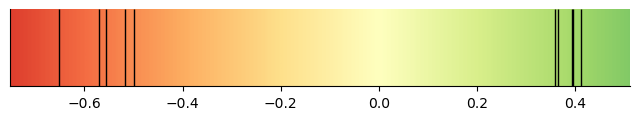

In [8]:
# Example x-points
x_points = [-0.651732, -0.570883, -0.556392, -0.517438, -0.498577, 0.411742, 0.394682, 0.393433, 0.364801, 0.359048]

# Create a gradient from red to green
gradient = np.linspace(-1, 1, 500).reshape(1, -1)  # Gradient centered at 0

# Create the plot
fig, ax = plt.subplots(figsize=(8, 1))
ax.imshow(gradient, aspect="auto", cmap="RdYlGn", extent=[-1, 1, -0.1, 0.1], vmin=-1, vmax=1)

# Add black lines at x_points
ax.vlines(x_points, ymin=-0.1, ymax=0.1, color='black', linewidth=1)
sns.despine()

# Customize the plot
ax.set_yticks([])  # Remove y-axis ticks
ax.set_xlim(min(x_points) - 0.1, max(x_points) + 0.1)

# Show the plot
plt.show()